In [ ]:
import sys
sys.path.append("../../../sampler-comparison")
sys.path.append("../../../sampler-evaluation")
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
sys.path.append("../../../../blackjax")
import os
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../../../blackjax')
sys.path.append('../sampler-comparison')
sys.path.append('../../../sampler-evaluation')
sys.path.append('../../../')
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sampler_evaluation
from sampler_comparison.samplers import samplers
import seaborn as sns
from functools import partial
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc


from sampler_comparison.samplers.general import make_log_density_fn
import blackjax
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

import numpy as np
import jax
import jax.numpy as jnp
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import blackjax
from blackjax.util import run_inference_algorithm
import blackjax

from blackjax.adaptation.unadjusted_alba import unadjusted_alba
from blackjax.adaptation.unadjusted_step_size import robnik_step_size_tuning
from blackjax.adaptation.unadjusted_alba import unadjusted_alba
import math
from blackjax.mcmc.adjusted_mclmc_dynamic import make_random_trajectory_length_fn
from functools import partial
from blackjax.adaptation.step_size import bisection_monotonic_fn
from blackjax.util import thin_algorithm
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc_no_tuning

def compose(f, g):
    return lambda x: f(g(x))


def blackjax_las(model, num_chains, key, ndims, num_adjusted_steps, diagonal_preconditioning=True, target_acceptance_rate=0.8, target_eevpd=5e-4):

    init_key, tune_key, unadjusted_key, adjusted_key = jax.random.split(key, 4)
    initial_position = jax.random.normal(init_key, (ndims,))

    logdensity_fn = make_log_density_fn(model)

    # sampler = partial(unadjusted_mclmc,num_tuning_steps=10000, integrator_type='mclachlan', diagonal_preconditioning=False, desired_energy_var=5e-4)

    # unadjusted_samples, metadata = sampler(return_samples=True)(
    #         model=model, 
    #         num_steps=100000,
    #         initial_position=jax.random.normal(jax.random.key(0), shape=(model.ndims,)), 
    #         key=jax.random.key(1))
    # print("step size, L", metadata['step_size'], metadata['L'])
    # # return unadjusted_samples

    # num_tuning_steps = 10000

    # warmup = unadjusted_alba(
    #         algorithm=blackjax.mclmc, 
    #         logdensity_fn=logdensity_fn, integrator=blackjax.mcmc.integrators.isokinetic_mclachlan, 
    #         target_eevpd=target_eevpd, 
    #         v=1., 
    #         num_alba_steps=num_tuning_steps // 3,
    #         preconditioning=diagonal_preconditioning,
    #         alba_factor=0.4,
    #         )

        
    # (blackjax_state_after_tuning, blackjax_mclmc_sampler_params), adaptation_info = warmup.run(tune_key, initial_position, num_tuning_steps)

    # print("step size, L", blackjax_mclmc_sampler_params['step_size'], blackjax_mclmc_sampler_params['L'])

    # num_tuning_integrator_steps = num_tuning_steps

    # raise Exception("stop")

    # expectations, _ = unadjusted_mclmc_no_tuning(
    #     initial_state=blackjax_state_after_tuning,
    #     integrator_type='mclachlan',
    #     step_size=metadata['step_size'],
    #     L=metadata['L'],
    #     inverse_mass_matrix=metadata['inverse_mass_matrix'],
    #     return_samples=True,
    #     return_only_final=False,
    #     incremental_value_transform=None,
    # )(stochastic_volatility_mams_paper, 100000, initial_position, unadjusted_key)

    # return expectations

    ### Phase 1: unadjusted ###

    integrator = blackjax.mcmc.integrators.isokinetic_mclachlan

    jax.debug.print("target_eevpd {x}", x=target_eevpd)
        
    # burn-in and adaptation
    num_alba_steps = 10000 // 3
    warmup = unadjusted_alba(
        algorithm=blackjax.mclmc, 
        logdensity_fn=logdensity_fn, integrator=integrator, 
        target_eevpd=target_eevpd, 
        # target_acceptance_rate=target_acceptance_rate,
        v=1, 
        num_alba_steps=num_alba_steps,
        preconditioning=diagonal_preconditioning,
        alba_factor=0.4,
        )

    (blackjax_state_after_tuning, blackjax_mclmc_sampler_params), adaptation_info = warmup.run(tune_key, initial_position, 10000)

    # sampling
    ess_per_sample = blackjax_mclmc_sampler_params['ESS']

    num_steps = math.ceil(num_chains // ess_per_sample)

    # load from absolute path in storage
    import numpy as np
    # metadata = np.load('/global/cfs/cdirs/m4031/reubenh/inverse_mass_matrix.npy')

    alg = blackjax.mclmc(
            logdensity_fn=logdensity_fn,
            L=blackjax_mclmc_sampler_params['L'],
            step_size=blackjax_mclmc_sampler_params['step_size'],
            inverse_mass_matrix=blackjax_mclmc_sampler_params['inverse_mass_matrix'],
            integrator=integrator,
        )

    thinning_rate = math.ceil(1/ess_per_sample)
    jax.debug.print("thinning_rate {x}", x=thinning_rate)

    # alg = thin_algorithm(
    #                 alg,
    #                 thinning=thinning_rate,
    #                 info_transform=lambda info: jax.tree.map(jnp.mean, info),
    #                 )

    # jax.debug.print("alg {x}", x=alg)

    transform = lambda state, info: (
                model.default_event_space_bijector(state.position),
                info,
            )

    final_output, (positions, infos) = run_inference_algorithm(
            rng_key=unadjusted_key,
            initial_state=blackjax_state_after_tuning,
            inference_algorithm=alg,
            # num_steps=num_steps//thinning_rate,
            num_steps=num_steps,
            transform=transform,
            progress_bar=False,
        )
    # return positions
    # samples = history.position
    samples = positions[::thinning_rate]




    ### Phase 2: adjusted ###

    # subsamples = samples[:th]
    subsamples = samples

    integration_steps_fn = make_random_trajectory_length_fn(True)


    # initial_states = jax.lax.map(lambda x: blackjax.adjusted_mclmc_dynamic.init(x, logdensity_fn, jax.random.key(0)), xs=subsamples)
    # initial_states = jax.lax.map(lambda x: blackjax.adjusted_mclmc_dynamic.init(x, logdensity_fn, jax.random.key(0)), xs=subsamples)

    num_steps_per_traj = blackjax_mclmc_sampler_params['L'] / blackjax_mclmc_sampler_params['step_size']

    def make_mams_step(key):
        def mams_step(inp):
            # init_key, run_key = jax.random.split(key, 2)


            step_size, positions, info, step_size_adaptation_state = inp
            jax.debug.print("step_size {step_size}", step_size=step_size)
            
            keys = jax.random.split(key, positions.shape[0])
            # num_steps_per_traj = blackjax_mclmc_sampler_params['L'] / step_size
            # num_steps_per_traj = 1

            alg = blackjax.adjusted_mclmc_dynamic(
                    logdensity_fn=logdensity_fn,
                    step_size=step_size,
                    integration_steps_fn=integration_steps_fn(num_steps_per_traj),
                    integrator=blackjax.mcmc.integrators.isokinetic_velocity_verlet,
                    inverse_mass_matrix=blackjax_mclmc_sampler_params['inverse_mass_matrix'],
                    L_proposal_factor=jnp.inf,
                )
            
            # run_keys = jax.random.split(run_key, positions.shape[0])

            def step_fn(pos_key):
                pos, key = pos_key
                init_key, run_key = jax.random.split(key, 2)
                return alg.step(
                    rng_key=run_key,
                    state=blackjax.adjusted_mclmc_dynamic.init(pos, logdensity_fn, init_key),
                )
            
            new_states, infos = jax.lax.map(step_fn, xs=(positions,keys))
            # jax.debug.print("new_states {x}", x=new_states.position[:, 0])
            # jax.debug.print("new_states shape {x}", x=new_states.position.shape)
            # jax.debug.print("infos adaptation step: {infos}", infos=(infos.acceptance_rate))
            return (step_size, new_states.position, infos, step_size_adaptation_state)

        return mams_step
        
    epsadap_update = bisection_monotonic_fn(target_acceptance_rate)
    step_size_adaptation_state_initial = (jnp.array([-jnp.inf, jnp.inf]), False)
        
    def tuning_step(inp):

        old_step_size, old_positions, old_infos, step_size_adaptation_state = inp
        acc_rate = old_infos.acceptance_rate.mean()
        # jax.debug.print("acc_rate {x}", x=old_infos.acceptance_rate)

        
        step_size_adaptation_state, new_step_size = epsadap_update(
            step_size_adaptation_state,
            old_step_size,
            acc_rate,
        )
        
        return (new_step_size, old_positions, old_infos, step_size_adaptation_state)
        # return (0, old_positions, old_infos, step_size_adaptation_state)

    # step = lambda key: compose(tuning_step, make_mams_step(key))

    def step_fn(inp, key):
        results =  make_mams_step(key)(inp)
        tuned_params = tuning_step(results)
        return tuned_params, tuned_params


    
    initial_adjusted_key, adjusted_key = jax.random.split(adjusted_key, 2)

    _, _, infos, _ = make_mams_step(initial_adjusted_key)((0.0, subsamples, None, step_size_adaptation_state_initial))
    # _, _, infos, _ = make_mams_step(initial_adjusted_key)((0.0, subsamples, None, step_size_adaptation_state_initial))
    # _, _, infos, _ = make_mams_step(initial_adjusted_key)((0.0, subsamples, None, step_size_adaptation_state_initial))
    
    
    positions = subsamples
    step_size = blackjax_mclmc_sampler_params['step_size']

    _, (step_sizes, positions, infos, step_size_adaptation_state) = jax.lax.scan(step_fn, (step_size, subsamples, infos, step_size_adaptation_state_initial), jax.random.split(adjusted_key, num_adjusted_steps))

    return samples, positions, infos, num_steps, step_size_adaptation_state, step_sizes


def las(num_adjusted_steps, num_chains, diagonal_preconditioning=True, target_acceptance_rate=0.8, target_eevpd=5e-4):

    def s(model, key):

        # logdensity_fn = make_log_density_fn(model)

        unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_size_adaptation_state, step_sizes = blackjax_las(
            model=model,
            key=key,
            ndims=model.ndims,
            num_adjusted_steps=num_adjusted_steps,
            num_chains=num_chains,
            diagonal_preconditioning=diagonal_preconditioning,
            target_acceptance_rate=target_acceptance_rate,
            target_eevpd=target_eevpd
        )
        # unadjusted_position = blackjax.adaptation.las.las(
        # unadjusted_position = blackjax_las(
        #     # logdensity_fn=logdensity_fn,
        #     model=model,
        #     key=key,
        #     ndims=model.ndims,
        #     num_adjusted_steps=num_adjusted_steps,
        #     num_chains=num_chains,
        #     diagonal_preconditioning=diagonal_preconditioning,
        #     target_acceptance_rate=target_acceptance_rate,
        #     target_eevpd=target_eevpd
        # )

        return unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_sizes
        # return unadjusted_position
        
    return s


2025-11-05 08:02:18.295237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762358538.311861 2187676 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762358538.316805 2187676 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-05 08:02:18.342777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = stochastic_volatility_mams_paper


In [3]:
# run las on banana
# model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# num_steps1 = 1000
num_adjusted_steps = 100
num_chains = 100
diagonal_preconditioning = False
print("running las")
# sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning, target_eevpd=2e-8)
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning, target_eevpd=5e-4)
unadjusted_samples, adjusted_samples, infos, num_steps_unadjusted, step_sizes = sampler(model, key=jax.random.key(0))
# unadjusted_samples = sampler(model, key=jax.random.key(0))
# print(samples)
# print(samples.shape)



running las
target_eevpd 0.0005000000237487257


thinning_rate 81
step_size 0.0


In [ ]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

plt.plot(unadjusted_error_at_each_step)
plt.show()


acc_prob_wanted: 0.800000011920929
exp_x: 1.6956892013549805
step_size 1.6956892013549805
bounds: (Array(0., dtype=float32), Array(inf, dtype=float32))
acc_rate_new: 0.0
new: (Array(0.8478446, dtype=float32), Array(0., dtype=float32))
acc_prob_wanted: 0.800000011920929
exp_x: 0.8478446006774902
step_size 0.8478446006774902
bounds: (Array(0., dtype=float32), Array(1.6956892, dtype=float32))
acc_rate_new: 2.2068259854940928e-36
new: (Array(0.4239223, dtype=float32), Array(0., dtype=float32))
acc_prob_wanted: 0.800000011920929
exp_x: 0.4239223003387451
step_size 0.4239223003387451
bounds: (Array(0., dtype=float32), Array(0.8478446, dtype=float32))
acc_rate_new: 0.20999999344348907
new: (Array(0.21196115, dtype=float32), Array(0., dtype=float32))
acc_prob_wanted: 0.800000011920929
exp_x: 0.21196115016937256
step_size 0.21196115016937256
bounds: (Array(0., dtype=float32), Array(0.4239223, dtype=float32))
acc_rate_new: 0.26103848218917847
new: (Array(0.10598058, dtype=float32), Array(0., dty

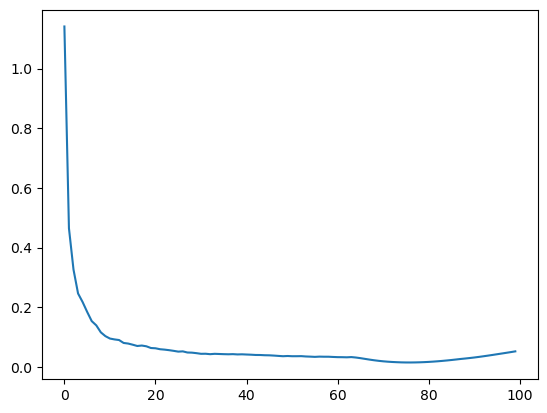

In [60]:
plt.plot(unadjusted_error_at_each_step)
plt.show()

In [61]:
adjusted_samples.shape

(100, 100, 2429)

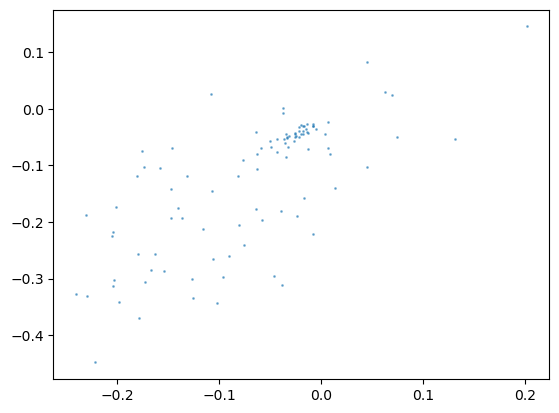

In [62]:
# # plt.plot(infos.acceptance_rate[:, 0])
# # plt.show()
# # show float not scientific notation
# plt.plot(step_sizes)
# _ = plt.hist(infos.acceptance_rate[-1, :])
# print((infos.is_accepted[0]))
# print(infos.is_divergent[0])
# print(infos.energy[:, 6])
# unadjusted_samples
plt.scatter(unadjusted_samples[:, 0], unadjusted_samples[:, 1], alpha=0.5, label='unadjusted', s=1.0)
# plt.scatter(adjusted_samples[-1, :, 0], adjusted_samples[-1, :, 1], alpha=0.5, label='adjusted', s=1.0)
# plt.legend()
# plt.show()

In [63]:
# effective sample size
# import sampler_evaluation
from blackjax.diagnostics import effective_sample_size
ess = effective_sample_size(unadjusted_samples[None, :, :])
ess.shape

(2429,)

In [64]:
ess.mean()

Array(63.637363, dtype=float32)

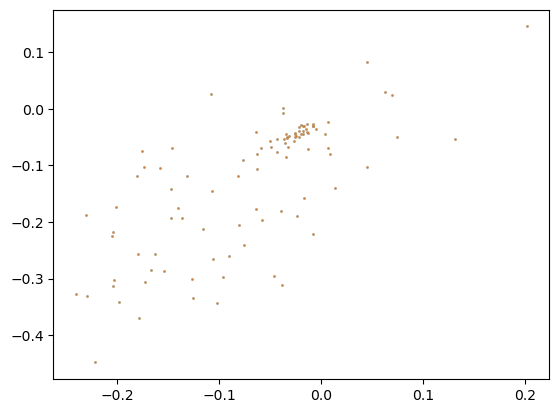

In [65]:
# unadjusted_samples[:, 1]
plt.scatter(unadjusted_samples[:, 0], unadjusted_samples[:, 1], alpha=0.5, label='unadjusted', s=1.0)
plt.scatter(adjusted_samples[0, :, 0], adjusted_samples[0, :, 1], alpha=0.5, label='adjusted', s=1.0)

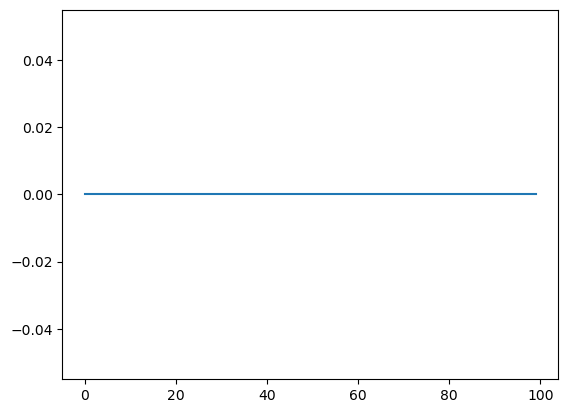

In [69]:
# print(unadjusted_samples[-1])

plt.plot(infos.acceptance_rate.mean(axis=1))

In [ ]:
# print(model.sample_transformations["square"].ground_truth_mean[1])
# print(unadjusted_samples[:,1].mean())

print((((model.sample_transformations["square"].ground_truth_mean - (unadjusted_samples**2).mean(axis=0)))**2 )/(model.sample_transformations["square"].ground_truth_standard_deviation**2))
""

((((model.sample_transformations["square"].ground_truth_mean -  (adjusted_samples**2).mean(axis=[0,1])))**2 ) / (model.sample_transformations["square"].ground_truth_standard_deviation**2))





[1.2296491e-04 2.8647494e-02 7.7543869e-03 ... 5.6269807e-03 2.1049572e+06
 1.4608264e+00]


Array([9.2436559e-05, 1.5841631e-04, 1.2926717e-03, ..., 3.3932149e-05,
       1.8797898e+06, 1.4616621e+00], dtype=float32)

In [66]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

adjusted_error_at_each_step = ((((adjusted_samples**2) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)


adjusted_error_at_each_step_single = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2))


fun = lambda i : ((((model.sample_transformations["square"].ground_truth_mean -  (adjusted_samples[i]**2).mean(axis=[0])))**2 ) / (model.sample_transformations["square"].ground_truth_standard_deviation**2))

adjusted_errs = jax.vmap(fun)(jnp.arange(adjusted_samples.shape[0])).mean(axis=-1)


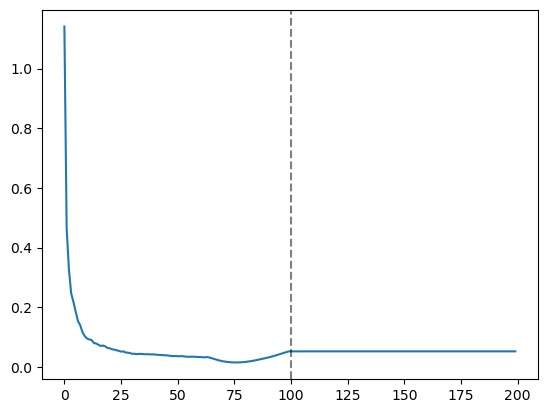

In [67]:
### COUNT GRADIENT CALLS!!!! TODO TODO
drop_first_n_steps = 0
plt.plot(np.concatenate([unadjusted_error_at_each_step[drop_first_n_steps:], adjusted_errs[:]]))
# log scale
# plt.plot(np.concatenate([adjusted_errs[:]]))
# plt.yscale('log')
# plt.plot(adjusted_errs)
# plt.plot(unadjusted_error_at_each_step)
# add a vertical line at the end of the unadjusted phase
plt.axvline(x=unadjusted_error_at_each_step.shape[0] - drop_first_n_steps, color='black', linestyle='--', alpha=0.5)
# plt.plot(unadjusted_error_at_each_step)
# save in sampler-comparison/sampler_comparison/experiments/results/figures
# plt.savefig(f'las_bias_{model.name}.png')
plt.show()
plt.close()
# plt.plot(adjusted_error_at_each_step)
# plt.show()
# plt.savefig(f'las_bias_adjusted_{model.name}.png')
# plt.close()

In [ ]:

sampler = partial(unadjusted_mclmc,num_tuning_steps=10000, integrator_type='mclachlan', diagonal_preconditioning=False, desired_energy_var=5e-4)

unadjusted_samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=100000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(model.ndims,)), 
        key=jax.random.key(1))



In [12]:
# save metadata['inverse_mass_matrix'] to absolute path in storage 

# np.save('/global/cfs/cdirs/m4031/reubenh/inverse_mass_matrix.npy', metadata)
metadata['L'], metadata['step_size']

(Array(21.049892, dtype=float32),
 Array(1.2742635, dtype=float32, weak_type=True))

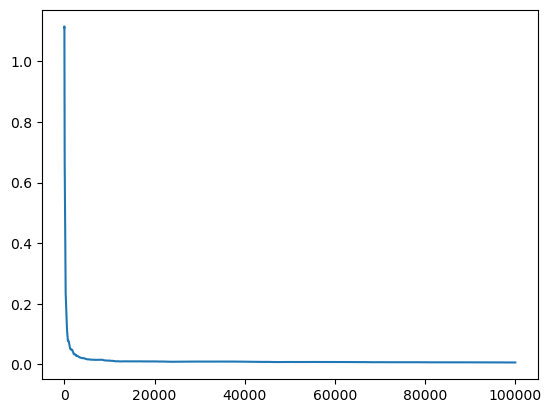

In [13]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

plt.plot(unadjusted_error_at_each_step[:])
plt.show()


In [ ]:
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# num_steps1 = 1000
num_adjusted_steps = 100
num_chains = 200
diagonal_preconditioning = True
print("running las")
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning)
unadjusted_samples_gaussian, adjusted_samples_gaussian, infos_gaussian, num_steps_unadjusted_gaussian = sampler(model, key=jax.random.key(0))

running las
num_alba_steps: 10000
thinning_rate: 50
new_num_alba_steps: 200
params before alba tuning (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True))
ess after alba (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True), Array([71.10184 , 60.654648], dtype=float32))
thinning_rate 152
alg SamplingAlgorithm(init=<function as_top_level_api.<locals>.init_fn at 0x7f0514320180>, step=<function thin_algorithm.<locals>.step_fn at 0x7f051448a340>)


(100, 199, 2)


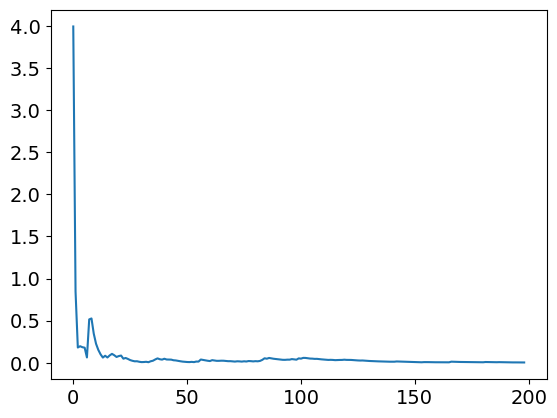

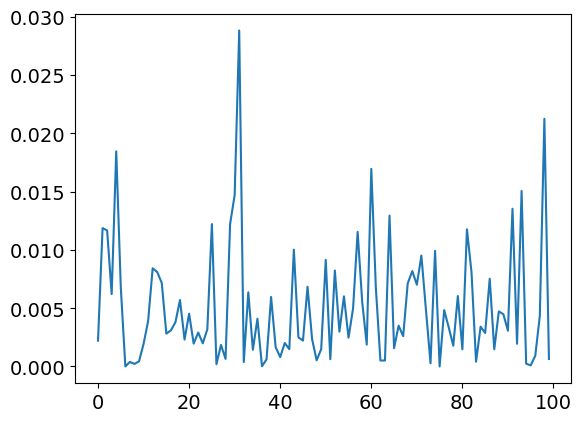

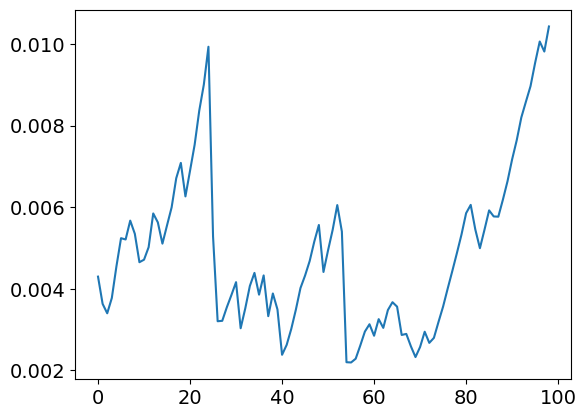

In [ ]:
def calculate_error(unadjusted_samples, adjusted_samples):

    print(adjusted_samples.shape)

    unadjusted_error_at_each_step = get_standardized_squared_error(
        unadjusted_samples[None, :, :], 
        f=model.sample_transformations["square"].fn,
        E_f=model.sample_transformations["square"].ground_truth_mean,
        Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
        contract_fn=jnp.max
        )[0]

    # bug: doesn't change when...
    adjusted_single = get_standardized_squared_error(
        adjusted_samples[5:, :, :], 
        f=model.sample_transformations["square"].fn,
        E_f=model.sample_transformations["square"].ground_truth_mean,
        Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
        contract_fn=jnp.max
        )[0]

    # note that we take mean across dims
    adjusted_error_at_each_step = ((((adjusted_samples**2).mean(axis=1) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)


    # adjusted_error_at_each_step_single = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2))

    return unadjusted_error_at_each_step, adjusted_error_at_each_step, adjusted_single

unadjusted_error_at_each_step_gaussian, adjusted_error_at_each_step_gaussian, adjusted_single_gaussian = calculate_error(unadjusted_samples_gaussian[:], adjusted_samples_gaussian)

plt.plot(unadjusted_error_at_each_step_gaussian)
plt.show()
plt.plot(adjusted_error_at_each_step_gaussian)
plt.show()
plt.plot(adjusted_single_gaussian[100:])
plt.show()



